# Линейная классификация

## Подключение библиотек

In [278]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt

## 1. Данные

### Разделение данных на тренировочные и тестовые

In [279]:
features_train = []
prices = []

with open('./dataset/preprocessed_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    feature_titles = [key for key in reader.fieldnames if key != 'Survived']
    
    for row in reader:
        sale_price = float(row['Survived'])
        feature_values = []
        for feature in feature_titles:
            value = row[feature]
            feature_values.append(float(value))
        
        features_train.append(feature_values)
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices)

x_train, x_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
scaler = StandardScaler()

for i, feature in enumerate(feature_titles):
    if feature in numerical_features:
        mean_value = np.nanmean(x_train[:, i])
        x_train[:, i] = np.where(np.isnan(x_train[:, i]), mean_value, x_train[:, i])
        x_test[:, i] = np.where(np.isnan(x_test[:, i]), mean_value, x_test[:, i])
        
        x_train[:, i] = scaler.fit_transform(x_train[:, i].reshape(-1, 1)).flatten()
        x_test[:, i] = scaler.transform(x_test[:, i].reshape(-1, 1)).flatten()

### Визуализация данных

In [280]:
table_data = []
headers = ["Index"] + feature_titles + ["Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="left"))

+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| Index   | Pclass   | Sex   | Age        | SibSp     | Parch     | Fare        | Embarked   | Survived   |
+=========+==========+=======+============+===========+===========+=============+============+============+
| 0       | 1        | 0     | -1.85798   | -0.474161 | 1.99885   | 0.980998    | 2          | 1          |
+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| 1       | 3        | 0     | -0.278303  | -0.474161 | -0.479327 | -0.469634   | 2          | 0          |
+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| 2       | 3        | 1     | -2.08365   | 0.348687  | 0.759763  | -0.406136   | 2          | 1          |
+---------+----------+-------+------------+-----------+-----------+-------------+------------+------------+
| 3       | 2        | 0    

### Оставляем только два признака (Age, Fare)

In [281]:
x_train = x_train[:, [2, 5]]
x_test = x_test[:, [2, 5]]


### Визуализируем оставшиеся данные

In [282]:
table_data = []
headers = ["Index", "Age", "Fare", "Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="left"))

+---------+------------+-------------+------------+
| Index   | Age        | Fare        | Survived   |
+=========+============+=============+============+
| 0       | -1.85798   | 0.980998    | 1          |
+---------+------------+-------------+------------+
| 1       | -0.278303  | -0.469634   | 0          |
+---------+------------+-------------+------------+
| 2       | -2.08365   | -0.406136   | 1          |
+---------+------------+-------------+------------+
| 3       | 0.549149   | -0.0802318  | 0          |
+---------+------------+-------------+------------+
| 4       | 1.07571    | -0.109651   | 0          |
+---------+------------+-------------+------------+
| 5       | 0.699595   | 2.38538     | 0          |
+---------+------------+-------------+------------+
| 6       | 0.173034   | -0.109651   | 1          |
+---------+------------+-------------+------------+
| 7       | 0.0225886  | -0.466609   | 0          |
+---------+------------+-------------+------------+
| 8       | 

## 2. Построение модели

1. **Предсказание (Sigmoid функция):**
   $$
   y_{\text{pred}} = \frac{1}{1 + e^{-(X \cdot \text{w})}}
   $$

2. **Градиент:**
   $$
   \text{grad} = \frac{1}{L} \cdot X^T \cdot (y_{\text{pred}} - Y)
   $$
   где:
   - $ L $ — количество объектов в выборке,
   - $ X $ — матрица признаков,
   - $ Y $ — вектор истинных меток.

3. **Обновление весов:**
   $$
   \text{w} = \text{w} - \text{lr} \cdot \text{grad}
   $$
   где:
   - $ \text{lr} $ — скорость обучения (learning rate).

In [283]:
class LinearClassificator:
    def __init__(self, iterations=10**100, lr=0.001, eps=1e-6, degree=1):
        self.iterations = iterations
        self.lr = lr
        self.eps = eps
        self.degree = degree
        self.weights = None  
        self.coef_ = None
        self.intercept_ = None  
        self.gradHistory = []
        
    def addIntercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def addPolynomialFeatures(self, X):
        if self.degree <= 1:
            return X  
        poly_features = [X ** i for i in range(1, self.degree + 1)]
        return np.hstack(poly_features)      
    
    def fit(self, X, Y):
        self.gradHistory.clear()
        X = self.addPolynomialFeatures(X)
        X = self.addIntercept(X)
        self.weights = np.zeros(X.shape[1])
        
        for i in range(self.iterations):
            y_pred = 1 / (1 + np.exp(-(X @ self.weights)))
            grad = (1 / X.shape[0]) * (X.T @ (y_pred - Y))
            self.weights -= self.lr * grad
            
            self.gradHistory.append(np.linalg.norm(grad))
            if i > 0 and np.linalg.norm(grad) < self.eps:
                print(f"Остановка на итерации {i} из-за маленького изменения MSE.")
                break
        
    def predict(self, X):
        X = self.addPolynomialFeatures(X)
        X = self.addIntercept(X)
        return X @ self.weights
        
    def getGradHistory(self):
        return self.gradHistory
    
    def getWeights(self):
        return self.weights
    
    def getAccuracy(self, X, Y):
        X = self.addPolynomialFeatures(X)
        X = self.addIntercept(X)
        y_pred = np.sign((X @ self.weights))
        y_pred = np.where(y_pred > 0, 1, 0)
        TP = np.sum((y_pred == 1) & (Y == 1))
        FP = np.sum((y_pred == 1) & (Y == 0))
        TN = np.sum((y_pred == 0) & (Y == 0))
        FN = np.sum((y_pred == 0) & (Y == 1))
        print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
        
        precision = TP / (TP + FP) 
        recall = TP / (TP + FN)
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        return (2 * precision * recall) / (precision + recall)
        

## 3. Тренировка 

Остановка на итерации 132237 из-за маленького изменения MSE.


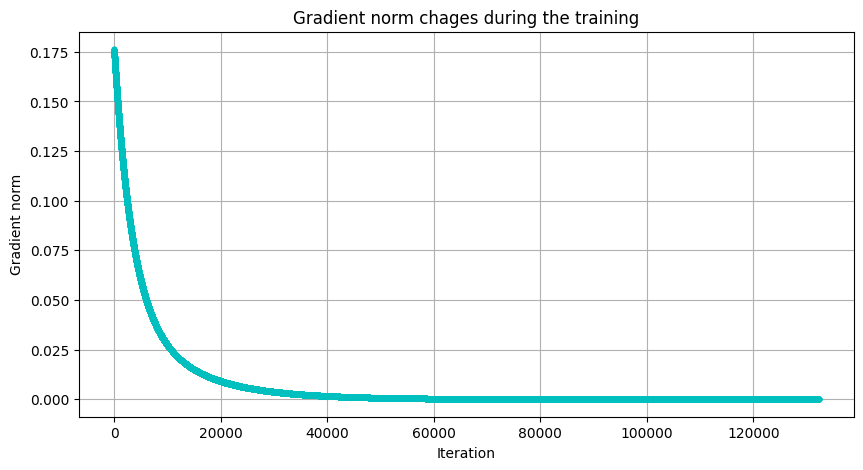

In [284]:
model = LinearClassificator()
model.fit(x_train, y_train)

gradHistory = model.getGradHistory()
plt.figure(figsize=(10, 5))
plt.plot(gradHistory, marker='.', linestyle=':', color='c')
plt.title('Gradient norm chages during the training')
plt.xlabel('Iteration')
plt.ylabel('Gradient norm')
plt.grid(True)
plt.show()

## 4. Оценка качества модели

In [285]:
print(f"Accuracy: {model.getAccuracy(x_test, y_test)}")

TP: 26, FP: 8, TN: 149, FN: 85
Precision: 0.7647058823529411
Recall: 0.23423423423423423
Accuracy: 0.3586206896551724


## 5. Визуализация модели

Визуализируем разделяющую прямую по этой формуле, где x1 задаем сами
$$
x_2 = -\frac{w_1}{w_2} \cdot x_1 - \frac{b}{w_2}
$$
P.S. сработает только при тренировке на двух признаках

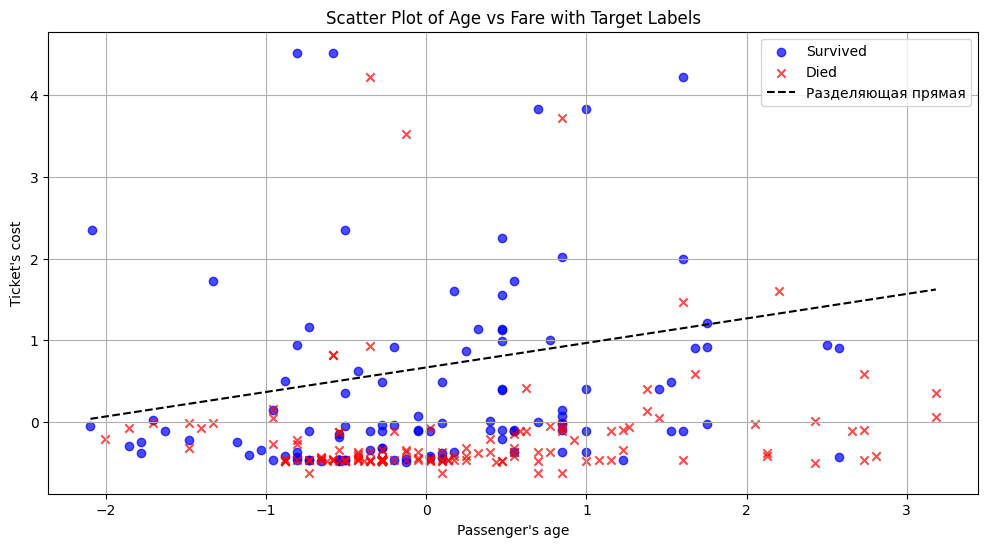

In [286]:
plt.figure(figsize=(12, 6))

age = x_test[:, 0]
age_survived = age[y_test == 1]  
age_died = age[y_test == 0] 

fare = x_test[:, 1] 
fare_survived = fare[y_test == 1]  
fare_died = fare[y_test == 0] 

plt.scatter(age_survived, fare_survived, color='blue', label='Survived', alpha=0.7, marker='o')
plt.scatter(age_died, fare_died, color='red', label='Died', alpha=0.7, marker='x')

w1, w2 = model.getWeights()[1:]
b = model.getWeights()[0]

x1_vals = np.linspace(age.min(), age.max(), 100)
x2_vals = -(w1 / w2) * x1_vals - (b / w2)

plt.plot(x1_vals, x2_vals, 'k--', label="Разделяющая прямая")

plt.xlabel("Passenger's age")
plt.ylabel("Ticket's cost")
plt.title('Scatter Plot of Age vs Fare with Target Labels')
plt.legend()
plt.grid(True)
plt.show()